### Business context

Online streaming platforms like Netflix have plenty of movies in their repositories and if we can build a recommendation system to recommend relevant movies to the users based on their historical interactions, this would improve customer satisfaction and hence improve revenue. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system. For this project, you can find the dataset [here](https://www.kaggle.com/somnambwl/bookcrossing-dataset)

### Task 1 - Understanding collaborative filtering and dataset

![alt text](collaborative_filtering.png "User Item Interactions")

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>    

In [26]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [27]:
# import dataset
movies = pd.read_csv('ratings_small.csv')


In [28]:
# observe the head of the dataset
movies.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


in this dataset, the variable `timestamp` is not helpful to build this recommendation system, so we can delete this variable from our dataset

In [29]:
# remove the variable timestamp from the dataset
movies = movies.drop(['timestamp'], axis=1)


### Task 2: Exploring the dataset

In [30]:
# see the shape of the dataset
movies.shape


(100004, 3)

In [31]:
# check for missing values
movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [32]:
# total number of unique users
movies['userId'].nunique()


671

In [33]:
# total number of unique movies
movies['movieId'].nunique()


9066

In [34]:
# which user has rated the most
movies['userId'].value_counts()


547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

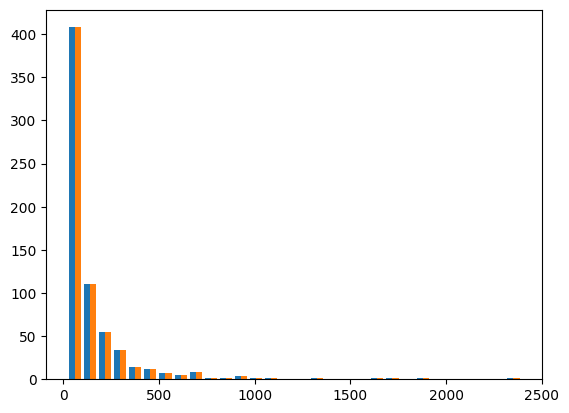

In [35]:
# create a histogram of all the interactions by all the users present in the dataset
interactions = movies.groupby('userId').count()
plt.hist(interactions, bins=30)
plt.show()

### Task 3: Creating user item matrix

Creating user item interactions matrix

In [36]:
# create the user item matrix using the ratings dataset - Hint: try using pivot function 
interactions_matrix = movies.pivot(index='userId', columns='movieId', values='rating')


In [37]:
# check the shape of the matrix
interactions_matrix.shape


(671, 9066)

In [38]:
# check head of the matrix and see how it looks like
interactions_matrix.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# replace all the missing values with zero
interactions_matrix = interactions_matrix.fillna(0)


### Task 4: Finding similar users

![alt text](cosine.png "Cosine Similarity")

In [40]:
# import cosine_similarity from sklearn
from sklearn.metrics.pairwise import cosine_similarity

def similar_users(user_id, interactions_matrix):
    # compute similarity of each user to the provided user
    similarity = []
    for user in range (1, interactions_matrix.shape[0]+1):
        sim = cosine_similarity([interactions_matrix.loc[user_id]], [interactions_matrix.loc[user]])
        similarity.append((user, sim))
    
    # sort by similarity
    similarity.sort(key=lambda x: x[1], reverse=True)
    
    # create list of just the user ids
    most_similar_users = [tup[0] for tup in similarity]
    
    # create list of similarity score
    similarity_score = [tup[1] for tup in similarity]
    
    # remove the user's own id
    most_similar_users.remove(user_id)
    
    # remove the user's own similarity score
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

In [41]:
# check the implemented function above
similar_users(564, interactions_matrix)[0][:5]


[306, 102, 518, 232, 119]

In [42]:
similar_users(564, interactions_matrix)[1][:5]

[array([[0.4752071]]),
 array([[0.45945837]]),
 array([[0.45806577]]),
 array([[0.42648819]]),
 array([[0.42188474]])]

### Task 5: Creating similarity based collaborative recommendation system

In [49]:
def recommendations(user_id, num_of_movies, user_item_interactions):
    # find the most similar users to the user_id for which we want to recommend movies
    most_similar_users = similar_users(user_id, user_item_interactions)[0]
    
    # find out those movies which this user has already interacted with
    movie_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_id] > 0)]))
    
    # create an empty list to store the recommended movies
    recommendations = []
    
    # copy those movies which are already interacted by user_id
    already_interacted = movie_ids.copy()
    
    # loop through each similar user from the list of most_similar_users
    for similar_user in most_similar_users:
        # implement the below code till the length of recommended movies does not become equal to num_of_movies
        if len(recommendations) < num_of_movies:
            # store all the movies interacted by each similar user to user_id
            similar_user_movie_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            # add those movies in the recommended list which are present in similar_user_movie_ids but not present in already_interacted
            recommendations.extend(list(similar_user_movie_ids.difference(already_interacted)))
            # now add all those movies into already_interacted which we already added in recommendations
            already_interacted = already_interacted.union(similar_user_movie_ids)
        else:
            break
    
    return recommendations[:num_of_movies]

In [50]:
# check the implemented function above
recommendations(564, 5, interactions_matrix)


[1537, 515, 1027, 2565, 524]

### Task 6: Conclusion

![alt text](CF.png "Similarity Based Collaborative Filtering")
image source - https://www.xpertup.com/downloads/movie-recommender-system/

Can you recommend three movies to a new user which do not have interactions history in the dataset?

In [51]:
# recommend top three movies to the new user
movies['movieId'].value_counts()[:3]


356    341
296    324
318    311
Name: movieId, dtype: int64